In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
path = os.path.normpath(os.getcwd() + os.sep + os.pardir)

In [3]:
winterFlexPath = os.path.join(path, 'Data', 'Flexibility', 'Winter User Full')

In [4]:
# Reads the price data, data was obtained through ERCOT website, it is the RTM LMP data

price = pd.read_csv(os.path.join(path, 'Data', 'Price', 'price.csv'), index_col='time')
price.index = pd.to_datetime(price.index)

In [5]:
with open(os.path.join(path, 'Data', 'summer2winter days.pickle'), 'rb') as handle:
    summer2winter = pickle.load(handle)
    
summer2winter = dict([(value, key) for key, value in summer2winter.items()])

In [6]:
weather = pd.DataFrame()
for file in os.listdir(os.path.join(path, 'Data', 'Weather')):
    temp = pd.read_csv(os.path.join(path, 'Data', 'Weather', file))
    temp.index = pd.to_datetime(temp[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    temp = temp.iloc[:, 5:]
    
    weather = pd.concat((weather, temp))
    
weather = weather[['Wind Speed', 'Relative Humidity', 'Temperature']]
weather = weather.resample('15T').interpolate()
weather = weather.loc[weather.index.year==2017]
weather = weather.loc[(weather.index.month == 1) | (weather.index.month == 11) | (weather.index.month == 12)
                  | (weather.index.month == 4)| (weather.index.month == 2)| (weather.index.month == 3)]

weather.loc[(weather.index.hour >= 15) & (weather.index.hour <= 19)].describe()

,Wind Speed,Relative Humidity,Temperature
count,3620.000000,3620.000000,3620.000000
mean,1.989959,81.368392,17.792541
std,0.978456,15.958097,5.522098
min,0.200000,29.850000,-1.000000
25%,1.200000,70.813750,14.500000
50%,1.800000,83.680000,18.750000
75%,2.600000,95.663750,22.000000
max,6.200000,100.000000,30.000000


In [7]:
for file in os.listdir(winterFlexPath):
    
    temp = pd.read_csv(os.path.join(winterFlexPath, file))
    dates = temp.columns
    flex_label = np.array([])
    temperature_label = np.array([])
    price_label = np.array([])
    existing_days = []
    
    for i in temp.columns:
        
        if pd.to_datetime(i) not in summer2winter:
            continue
        else:
            existing_days.append(i)
            
        new_winter_day = pd.to_datetime(summer2winter[pd.to_datetime(i)])
        
        flex_avg = temp[i].iloc[15:20].copy()
        flex_avg = flex_avg.mean()
        
        other_avg = np.concatenate((temp[i].loc[0:14], temp[i].loc[20:])).mean()
        
        delta = (flex_avg - other_avg)/flex_avg
        
        # Flexibility label
        if delta >= 0.4 and np.count_nonzero(temp[i].iloc[15:20] > 0) > 0:
            flex_label = np.append(flex_label, 2)
        elif (delta < 0.4 and delta >= 0.2) and (np.count_nonzero(temp[i].iloc[15:20] > 0) > 0):
            flex_label = np.append(flex_label, 1)
        else:
            flex_label = np.append(flex_label, 0)
        
        # Price label - here the price is much lower than Summer
        price_dr_avg = price.loc[new_winter_day:new_winter_day+timedelta(days=1)-timedelta(minutes=15)][60:80]
        
        if (price_dr_avg.values >= 28).any():
            price_label = np.append(price_label, 2)
        else:
            price_label = np.append(price_label, 0)
        
        # Temperature label
        weather_temp = weather.loc[new_winter_day:new_winter_day+timedelta(days=1)-timedelta(minutes=15)].copy()
        temp_avg = weather_temp['Temperature'][60:80].copy()
        
        if temp_avg.mean() >= 22:
           temperature_label = np.append(temperature_label, 0)
        elif temp_avg.mean() < 22 and temp_avg.mean() >= 18.75:
           temperature_label = np.append(temperature_label, 1)
        elif temp_avg.mean() < 18.75:
           temperature_label = np.append(temperature_label, 2)
                
    temp = temp[existing_days]
    temp.loc[len(temp)] = flex_label
    temp.loc[len(temp)] = price_label
    temp.loc[len(temp)] = temperature_label
    
    temp.to_csv(os.path.join(path, 'Data', 'Flexibility', 'Winter with label', f'{file} label.csv'), index=False)
    

C:\Users\sienna\AppData\Local\Temp\ipykernel_26480\3113503402.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  delta = (flex_avg - other_avg)/flex_avg
C:\Users\sienna\AppData\Local\Temp\ipykernel_26480\3113503402.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  delta = (flex_avg - other_avg)/flex_avg
C:\Users\sienna\AppData\Local\Temp\ipykernel_26480\3113503402.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  delta = (flex_avg - other_avg)/flex_avg
C:\Users\sienna\AppData\Local\Temp\ipykernel_26480\3113503402.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  delta = (flex_avg - other_avg)/flex_avg
C:\Users\sienna\AppData\Local\Temp\ipykernel_26480\3113503402.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  delta = (flex_avg - other_avg)/flex_avg
C:\Users\sienna\AppData\Local\Temp\ipykernel_26480\3113503402.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  delta = 

In [8]:
flex_full = pd.DataFrame()

for file in os.listdir(os.path.join(path, 'Data', 'Flexibility', 'Winter with label')):
    temp = pd.read_csv(os.path.join(path, 'Data', 'Flexibility', 'Winter with label', file))
    for i in temp.columns:
        flex_full = pd.concat([flex_full, temp[i]], axis=1)
        
flex_full.columns = range(flex_full.columns.size)
flex_full.to_csv(os.path.join(path, 'Data', 'Flexibility', 'Winter Full.csv'), index=False)

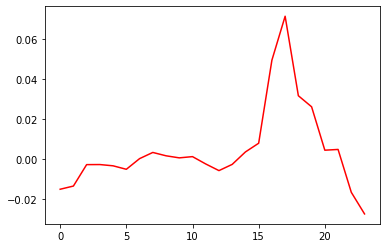

In [12]:
flex = pd.DataFrame()

for i in flex_full.columns:
    temp = flex_full[i].copy()
    if temp.iloc[-3] == 2:
        flex = pd.concat([flex, temp], axis=1)

plt.plot(flex.iloc[:-3, :].mean(axis=1), c='red')